# The mpirun command:
mpirun --np 6 dask-mpi --scheduler-file /proj/kstein/ESM2M/scheduler.json --no-nanny

In [1]:
from dask.distributed import Client
client = Client(scheduler_file='/proj/kstein/ESM2M/scheduler.json')

In [2]:
client

Client Scheduler: tcp://203.247.189.225:8786 Dashboard: http://203.247.189.225:8787/status,Cluster Workers: 5 Cores: 180 Memory: 4.05 TB


In [3]:
import numpy as np
import xarray as xr 
from tqdm import tqdm
import gsw
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cf
import dask
import time

In [4]:
def process_coords(ds, concat_dim='time', drop=True, extra_coord_vars=['time_bound']):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = [v for v in ds.data_vars if concat_dim not in ds[v].dims]
    for ecv in extra_coord_vars:
        if ecv in ds:
            coord_vars += extra_coord_vars
    if drop:
        return ds.drop(coord_vars)
    else:
        return ds.set_coords(coord_vars)

In [5]:
def open_ESM2M_5D(files):
    ds = []
    ds = xr.open_mfdataset(files,
                           combine='nested',
                           concat_dim='time',
                           chunks={'time': 1},
                           preprocess=process_coords,
                           parallel='True',
                          decode_cf=True,
                          decode_times=True)
    ds = ds.assign_coords(xt_ocean=(((ds.xt_ocean + 180) % 360) - 180))
    ds = ds.roll(xt_ocean=180,roll_coords=True)
    return ds

In [6]:
ens_dir = '/proj/krodgers/ESM2M/ENSEMBLE/'
scenario = 'RCP85'
ensembles = [ens for ens in range(101,131)]
ensembles.remove(101)
ensembles.remove(107)
ensembles.remove(110)
ensembles.remove(111)
ensembles.remove(114)
ensembles.remove(116)
ensembles.remove(117)
ensembles.remove(122)
ensembles.remove(127)
ensembles.remove(130)
domain = 'OCN_5D'
var = 'temp'


ens_files = []
for member in ensembles:
    datadir = ens_dir + 'ENSEMBLE_' + scenario + '/ENS' + str(member) + '/' + domain + '/'
    files = [datadir + 
             var + '_1x1_ens' + 
             str(member) + '_5d_' + 
             str(year) +'.nc'  for year in range(1950,2101)]
    ens_files.append(files)
    
ds_temp = xr.open_mfdataset(ens_files,
                            chunks={'time': 1},
                            combine='nested',
                            concat_dim=[[*ensembles],'time'],
                            parallel='True',
                            preprocess=process_coords,
                            decode_cf=False,
                            decode_times=False)

In [7]:
ds_temp

<xarray.Dataset>
Dimensions:     (concat_dim: 20, st_ocean: 50, time: 11023, xt_ocean: 360, yt_ocean: 180)
Coordinates:
  * yt_ocean    (yt_ocean) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * st_ocean    (st_ocean) float64 5.0 15.0 25.0 ... 4.95e+03 5.316e+03
  * concat_dim  (concat_dim) int64 102 103 104 105 106 ... 124 125 126 128 129
  * xt_ocean    (xt_ocean) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * time        (time) float64 2.5 7.5 12.5 ... 3.466e+04 3.467e+04 3.467e+04
Data variables:
    temp        (concat_dim, time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 50, 180, 360), meta=np.ndarray>
Attributes:
    filename:      19500101.ocean_5day.nc
    title:         ESM2M-C1_all_historical_HC2_HighFreqDiag_ens102
    grid_type:     mosaic
    grid_tile:     1
    history:       fregrid_parallel --input_mosaic mosaic/ocean_mosaic.nc --l...
    NCO:           4.0.3
    code_version:  $Name: bronx-10_performance_z1l $

The two cells below were used to find the problem ensembles.

In [8]:
ens_dir = '/proj/krodgers/ESM2M/ENSEMBLE/'
scenario = 'RCP85'
ensembles = [ens for ens in range(101,131)]
ensembles.remove(101)
ensembles.remove(107)
ensembles.remove(110)
ensembles.remove(111)
ensembles.remove(114)
ensembles.remove(116)
ensembles.remove(117)
ensembles.remove(122)
ensembles.remove(127)
ensembles.remove(130)
domain = 'OCN_5D'
var = 'salt'


ens_files = []
for member in ensembles:
    datadir = ens_dir + 'ENSEMBLE_' + scenario + '/ENS' + str(member) + '/' + domain + '/'
    files = [datadir + 
             var + '_1x1_ens' + 
             str(member) + '_5d_' + 
             str(year) +'.nc'  for year in range(1950,2101)]
    ens_files.append(files)
    
ds_salt = xr.open_mfdataset(ens_files,
                            chunks={'time': 1},
                            combine='nested',
                            concat_dim=[[*ensembles],'time'],
                            parallel='True',
                            preprocess=process_coords,
                            decode_cf=False,
                            decode_times=False)

In [9]:
ds_salt

<xarray.Dataset>
Dimensions:     (concat_dim: 20, st_ocean: 50, time: 11023, xt_ocean: 360, yt_ocean: 180)
Coordinates:
  * yt_ocean    (yt_ocean) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * st_ocean    (st_ocean) float64 5.0 15.0 25.0 ... 4.95e+03 5.316e+03
  * concat_dim  (concat_dim) int64 102 103 104 105 106 ... 124 125 126 128 129
  * xt_ocean    (xt_ocean) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * time        (time) float64 2.5 7.5 12.5 ... 3.466e+04 3.467e+04 3.467e+04
Data variables:
    salt        (concat_dim, time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 50, 180, 360), meta=np.ndarray>
Attributes:
    filename:      19500101.ocean_5day.nc
    title:         ESM2M-C1_all_historical_HC2_HighFreqDiag_ens102
    grid_type:     mosaic
    grid_tile:     1
    history:       fregrid_parallel --input_mosaic mosaic/ocean_mosaic.nc --l...
    NCO:           4.0.3
    code_version:  $Name: bronx-10_performance_z1l $

In [10]:
ens_dir = '/proj/krodgers/ESM2M/ENSEMBLE/'
scenario = 'RCP85'
ensembles = [ens for ens in range(101,131)]
ensembles.remove(101)
ensembles.remove(107)
ensembles.remove(110)
ensembles.remove(111)
ensembles.remove(114)
ensembles.remove(116)
ensembles.remove(117)
ensembles.remove(122)
ensembles.remove(127)
ensembles.remove(130)
domain = 'OCN_5D'
var = 'pot_rho_0'


ens_files = []
for member in ensembles:
    datadir = ens_dir + 'ENSEMBLE_' + scenario + '/ENS' + str(member) + '/' + domain + '/'
    files = [datadir + 
             var + '_1x1_ens' + 
             str(member) + '_5d_' + 
             str(year) +'.nc'  for year in range(1950,2101)]
    ens_files.append(files)
    
ds_rho = xr.open_mfdataset(ens_files,
                            chunks={'time': 1},
                            combine='nested',
                            concat_dim=[[*ensembles],'time'],
                            parallel='True',
                            preprocess=process_coords,
                            decode_cf=False,
                            decode_times=False)

In [11]:
ds_rho

<xarray.Dataset>
Dimensions:     (concat_dim: 20, st_ocean: 50, time: 11023, xt_ocean: 360, yt_ocean: 180)
Coordinates:
  * yt_ocean    (yt_ocean) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * st_ocean    (st_ocean) float64 5.0 15.0 25.0 ... 4.95e+03 5.316e+03
  * concat_dim  (concat_dim) int64 102 103 104 105 106 ... 124 125 126 128 129
  * xt_ocean    (xt_ocean) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * time        (time) float64 2.5 7.5 12.5 ... 3.466e+04 3.467e+04 3.467e+04
Data variables:
    pot_rho_0   (concat_dim, time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 50, 180, 360), meta=np.ndarray>
Attributes:
    filename:      19500101.ocean_5day.nc
    title:         ESM2M-C1_all_historical_HC2_HighFreqDiag_ens102
    grid_type:     mosaic
    grid_tile:     1
    history:       fregrid_parallel --input_mosaic mosaic/ocean_mosaic.nc --l...
    NCO:           4.0.3
    code_version:  $Name: bronx-10_performance_z1l $

In [12]:
ens_dir = '/proj/krodgers/ESM2M/ENSEMBLE/'
scenario = 'RCP85'
ensembles = [ens for ens in range(101,131)]
ensembles.remove(101)
ensembles.remove(107)
ensembles.remove(110)
ensembles.remove(111)
ensembles.remove(114)
ensembles.remove(116)
ensembles.remove(117)
ensembles.remove(122)
ensembles.remove(127)
ensembles.remove(130)
domain = 'OCN_5D'
var = 'o2'


ens_files = []
for member in ensembles:
    datadir = ens_dir + 'ENSEMBLE_' + scenario + '/ENS' + str(member) + '/' + domain + '/'
    files = [datadir + 
             var + '_1x1_ens' + 
             str(member) + '_5d_' + 
             str(year) +'.nc'  for year in range(1950,2101)]
    ens_files.append(files)
    
ds_o2 = xr.open_mfdataset(ens_files,
                            chunks={'time': 1},
                            combine='nested',
                            concat_dim=[[*ensembles],'time'],
                            parallel='True',
                            preprocess=process_coords,
                            decode_cf=False,
                            decode_times=False)

In [13]:
ds = xr.merge([ds_temp,ds_salt,ds_rho,ds_o2])
ds['temp'] = ds.temp.where(ds.temp>-1e19)
ds = ds.rename({'pot_rho_0':'rho'})
ds = ds.rename({'concat_dim' : 'ensemble'})
ds['time'] = xr.cftime_range(start='1950-01-01', end='2100-12-31', 
                             freq='5D', 
                             calendar='noleap')
ds = ds.assign_coords(xt_ocean=(((ds.xt_ocean + 180) % 360) - 180))
ds = ds.roll(xt_ocean=180,roll_coords=True)
ds

<xarray.Dataset>
Dimensions:   (ensemble: 20, st_ocean: 50, time: 11023, xt_ocean: 360, yt_ocean: 180)
Coordinates:
  * yt_ocean  (yt_ocean) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 4.588e+03 4.95e+03 5.316e+03
  * ensemble  (ensemble) int64 102 103 104 105 106 108 ... 124 125 126 128 129
  * xt_ocean  (xt_ocean) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time      (time) object 1950-01-01 00:00:00 ... 2100-12-27 00:00:00
Data variables:
    temp      (ensemble, time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 50, 180, 360), meta=np.ndarray>
    salt      (ensemble, time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 50, 180, 360), meta=np.ndarray>
    rho       (ensemble, time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 50, 180, 360), meta=np.ndarray>
    o2        (ensemble, time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 50, 180, 360), meta=np.ndarray>

Calculating the MI works the same way.

Select the area/time you want (assign a different dataset name for testing):

In [14]:
lons=[-85,25]
lats=[25,70]
depths=[0,400]
ds = ds.sel(xt_ocean = slice(lons[0],lons[1]))
ds = ds.sel(yt_ocean =slice(lats[0],lats[1]))
ds = ds.sel(st_ocean =slice(depths[0],depths[1]))
ds

<xarray.Dataset>
Dimensions:   (ensemble: 20, st_ocean: 29, time: 11023, xt_ocean: 110, yt_ocean: 45)
Coordinates:
  * yt_ocean  (yt_ocean) float64 25.5 26.5 27.5 28.5 ... 66.5 67.5 68.5 69.5
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 35.0 ... 270.6 298.3 335.7 384.6
  * ensemble  (ensemble) int64 102 103 104 105 106 108 ... 124 125 126 128 129
  * xt_ocean  (xt_ocean) float64 -84.5 -83.5 -82.5 -81.5 ... 21.5 22.5 23.5 24.5
  * time      (time) object 1950-01-01 00:00:00 ... 2100-12-27 00:00:00
Data variables:
    temp      (ensemble, time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 29, 45, 110), meta=np.ndarray>
    salt      (ensemble, time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 29, 45, 110), meta=np.ndarray>
    rho       (ensemble, time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 29, 45, 110), meta=np.ndarray>
    o2        (ensemble, time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 29, 45, 110), meta=np.ndarray>

In [15]:
o2sol = xr.apply_ufunc(gsw.O2sol_SP_pt,
                        ds.salt.chunk(),ds.temp.chunk() - 273.15,
                        dask='parallelized',
                        output_dtypes=[ds.temp.dtype])

In [16]:
O2PP = 0.21*(ds.o2*1e6)/o2sol

In [17]:
def metabolic_index(T,O2PP,A0 = 3.1e-14,E0 = 0.87,B=1,n=0):
    kB = 8.617333262145e-5
    B = 1000
    n = -.21
    den = np.exp(-E0/(kB*T))
    MI = A0 * (B**n) * (O2PP/den)
    
    return MI

In [18]:
met_index = xr.apply_ufunc(metabolic_index,
                           ds.temp.chunk(),O2PP.chunk(),
                           dask='parallelized',
                           output_dtypes=[ds.temp.dtype])

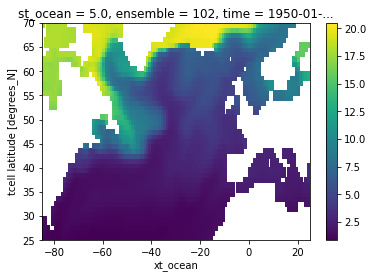

In [19]:
met_index[0,0,0,:,:].plot()

Calculate the ensembe mean metabolic index for the last ten years of the run:

In [20]:
met_index.time

<xarray.DataArray 'time' (time: 11023)>
array([cftime.DatetimeNoLeap(1950-01-01 00:00:00),
       cftime.DatetimeNoLeap(1950-01-06 00:00:00),
       cftime.DatetimeNoLeap(1950-01-11 00:00:00), ...,
       cftime.DatetimeNoLeap(2100-12-17 00:00:00),
       cftime.DatetimeNoLeap(2100-12-22 00:00:00),
       cftime.DatetimeNoLeap(2100-12-27 00:00:00)], dtype=object)
Coordinates:
  * time     (time) object 1950-01-01 00:00:00 ... 2100-12-27 00:00:00

In [21]:
MI_ENSmean_2090_2100 = met_index[:,-730:,:,:,:].mean(axis=0)
MI_ENSmean_2090_2100

<xarray.DataArray (time: 730, st_ocean: 29, yt_ocean: 45, xt_ocean: 110)>
dask.array<mean_agg-aggregate, shape=(730, 29, 45, 110), dtype=float32, chunksize=(1, 29, 45, 110)>
Coordinates:
  * yt_ocean  (yt_ocean) float64 25.5 26.5 27.5 28.5 ... 66.5 67.5 68.5 69.5
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 35.0 ... 270.6 298.3 335.7 384.6
  * xt_ocean  (xt_ocean) float64 -84.5 -83.5 -82.5 -81.5 ... 21.5 22.5 23.5 24.5
  * time      (time) object 2091-01-01 00:00:00 ... 2100-12-27 00:00:00

Calculate time and depth average

In [22]:
MI_ENSmean_2090_2100 = MI_ENSmean_2090_2100.mean(axis=0)
MI_ENSmean_2090_2100 = MI_ENSmean_2090_2100.mean(axis=0)
MI_ENSmean_2090_2100

<xarray.DataArray (yt_ocean: 45, xt_ocean: 110)>
dask.array<mean_agg-aggregate, shape=(45, 110), dtype=float32, chunksize=(45, 110)>
Coordinates:
  * yt_ocean  (yt_ocean) float64 25.5 26.5 27.5 28.5 ... 66.5 67.5 68.5 69.5
  * xt_ocean  (xt_ocean) float64 -84.5 -83.5 -82.5 -81.5 ... 21.5 22.5 23.5 24.5

In [23]:
MI_ENSmean_2090_2100 = MI_ENSmean_2090_2100.compute()

In [24]:
MI_ENSmean_2090_2100

<xarray.DataArray (yt_ocean: 45, xt_ocean: 110)>
array([[ 0.8040964 ,  0.85284   ,  0.86699504, ...,         nan,
                nan,         nan],
       [ 0.9387438 ,  0.92320395,  0.8828521 , ...,         nan,
                nan,         nan],
       [ 0.9758551 ,  0.9368215 ,  0.7402878 , ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan, 15.329493  , ...,         nan,
                nan,         nan],
       [        nan,         nan, 15.46611   , ...,         nan,
                nan,         nan],
       [14.8805485 ,         nan, 15.350515  , ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * yt_ocean  (yt_ocean) float64 25.5 26.5 27.5 28.5 ... 66.5 67.5 68.5 69.5
  * xt_ocean  (xt_ocean) float64 -84.5 -83.5 -82.5 -81.5 ... 21.5 22.5 23.5 24.5

Note the data is there now.

You plot it the xarray way:

/home/kstein/miniconda3/envs/research3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'color'
  s)


Text(0.5, 1.0, 'ESM2M ensemble average cod \nmetabolic index, 2090-2100')

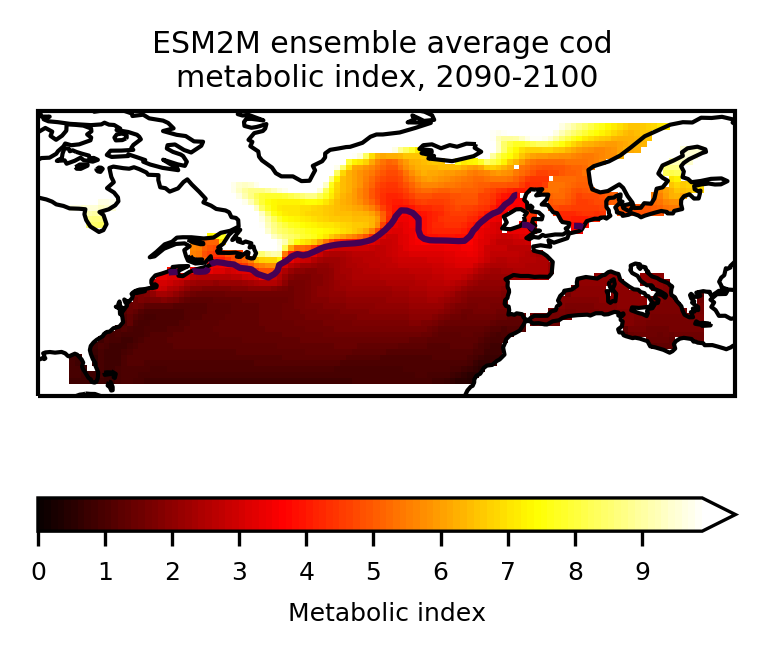

In [25]:
plt.rcParams.update({'font.size': 6})
levs = np.arange(0,10,.1)
fig = plt.figure(figsize=(3, 3), dpi=300, facecolor='w', edgecolor='k')
ax = plt.subplot2grid((1, 1), (0, 0),
                      projection=ccrs.PlateCarree())
ax.coastlines('110m')
cl = MI_ENSmean_2090_2100.plot(levels=levs,
                               transform=ccrs.PlateCarree(),
                               cmap=plt.cm.hot,
                               cbar_kwargs={'orientation' : 'horizontal',
                                           'label' : 'Metabolic index'})
MI_ENSmean_2090_2100.plot.contour(levels=[3.7],
                                  transform=ccrs.PlateCarree(),
                                  color='black')
plt.title('ESM2M ensemble average cod \n' +
         'metabolic index, 2090-2100')

But it's probably easier to plot more "normally".

Text(0.5, 1.0, 'ESM2M ensemble average cod \nmetabolic index, 2090-2100')

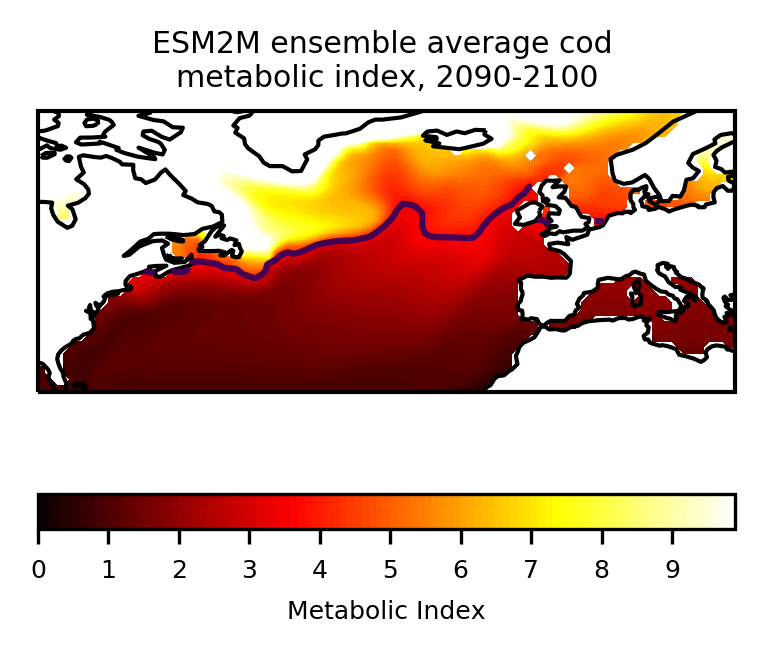

In [26]:
plt.rcParams.update({'font.size': 6})
fig = plt.figure(num=1,figsize=(3, 3), dpi=300, facecolor='w', edgecolor='k')
ax = plt.subplot2grid((1, 1), (0, 0),
                      projection=ccrs.PlateCarree())
ax.coastlines('110m')
cl = ax.contourf(MI_ENSmean_2090_2100.xt_ocean.data,
                 MI_ENSmean_2090_2100.yt_ocean.data,
                 MI_ENSmean_2090_2100.data,
                 levels=levs,
                 transform=ccrs.PlateCarree(),
                 cmap=plt.cm.hot)
plt.colorbar(cl,
             ax=ax,
             orientation='horizontal',
             label='Metabolic Index')
ax.contour(MI_ENSmean_2090_2100.xt_ocean.data,
           MI_ENSmean_2090_2100.yt_ocean.data,
           MI_ENSmean_2090_2100.data,
          levels=[3.7],
          color='black')
plt.title('ESM2M ensemble average cod \n' +
         'metabolic index, 2090-2100')